<a href="https://colab.research.google.com/github/Hetvi07/Age_Group_Detection_From_Images/blob/master/deep_learning_CNN_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Mount Google Drive {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Imports
# Please refer to requirements.txt for a full list of all libraries and their versions used in this project.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Setting random seeds to reduce the amount of randomness in the neural net weights and results.
# The results may still not be exactly reproducible.
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Checking the installed version of TensorFlow.
# The code in this notebook was written using TensorFlow version 2.2.0.

tf.__version__

'2.2.0'

**Ensure that the Runtime Type for this notebook is set to GPU**.

Run the code below to check for GPU. If a GPU device is not found, change the runtime type under *Runtime* &#10141; *Change runtime type* &#10141; *Hardware accelerator* &#10141; *GPU* and run the notebook from the beginning again.

In [ ]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Deep Learning: Data Importing

In [ ]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/Faces_datasets/zipped_datasets/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [ ]:
# Importing the table showing the breakdown of age-ranges into classes.

combined_classes = pd.read_csv("/content/drive/My Drive/Age_classification_with_faces/input_output/combined_faces_classes_summary.csv")
combined_classes

,Class label,Age-ranges (classes),No. of images,Class balance (%)
0,0,1 - 2,3192,9.53
1,1,3 - 9,2816,8.41
2,2,10 - 20,3136,9.37
3,3,21 - 25,3474,10.37
4,4,26 - 27,3217,9.61
5,5,28 - 31,3063,9.15
6,6,32 - 36,3086,9.22
7,7,37 - 45,3207,9.58
8,8,46 - 54,2802,8.37
9,9,55 - 65,2796,8.35


In [ ]:
# Importing the training and testing datasets to create tensors of images using the filename paths.

train_df = pd.read_csv("/content/drive/My Drive/Age_classification_with_faces/input_output/images_filenames_labels_train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Age_classification_with_faces/input_output/images_filenames_labels_test.csv")

In [ ]:
train_df.head()

,filename,age,target
0,/content/content/combined_faces/18_369.jpg,18,2
1,/content/content/combined_faces/5_42.jpg,5,1
2,/content/content/combined_faces/5_204.jpg,5,1
3,/content/content/combined_faces/39_24.jpg,39,7
4,/content/content/combined_faces/22_41.jpg,22,3


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,7
2,/content/content/combined_faces/40_177.jpg,40,7
3,/content/content/combined_faces/36_267.jpg,36,6
4,/content/content/combined_faces/8_349.jpg,8,1


In [ ]:
train_df.shape

(23440, 3)

In [ ]:
test_df.shape

(10046, 3)

### Pandas *DataFrame* vs. TensorFlow *Dataset Pipeline*

In order to prepare the dataset of images to be passed into the neural network, I first tried converting the images into a **Panadas DataFrame**, with individual pixel values as columns and the images as rows. However, as all the pixel values had to be of type float (scaled down from 0-255 integers to 0-1 floats), this resulted in a **huge and heavy dataframe** (33,486 rows X 40,000 columns). Loading this dataframe into the memory just before running the neural network led to constant ***\"Out of Memory\"* errors (in spite of using the GPU and 25GB High-RAM runtime types available in Google Colab Pro)**.

So, to avoid these errors, another approach was taken to prepare the images dataset for the neural network. This approach involved creating **dataset pipelines using TensorFlow's in-built *.Dataset* API**, as shown below. This approach **significantly reduced RAM consumption**, as the images are now only being loaded into the memory in defined batch sizes as and when they are needed by the neural network. More detailed explanations about this approach can be found in this [article](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428).

In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(train_df['filename'])
train_labels_list = list(train_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining the number of classes and a function to read, decode the image from given tensor and one-hot encode the image label class.

num_classes = 11

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(3)
train_dataset = train_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

## Deep Learning: Classification Modelling

After correctly importing the datasets, I will now build a basic **Convolutional Neural Network (CNN) model** that performs with reasonable accuracy on the given data and with the given number of total parameters. **The idea is to get an initial benchmark on the model’s performance, and then incrementally try different techniques to see whether they improve the performance from that point or not.**

### Initial Modelling with CNN

Although it is a well known fact that [people of different races age differently](https://www.aarp.org/disrupt-aging/stories/ideas/info-2017/cliches-that-are-true.html), for the purposes of the neural network defined below, **all facial images will be converted to grayscale** from RGB coloured images. As this may negatively affect the model's performance, a comparison will also be done in the next section with a neural network built using RGB coloured images.

After some back-and-forth experimentation with the CNN architecture, I decided to fix the following architecture to begin with.

In [ ]:
# Defining the architecture of the sequential neural network.

cnn1 = Sequential()

cnn1.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
cnn1.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn1.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2,2)))
# cnn1.add(MaxPooling2D(pool_size=(2,2)))

cnn1.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2,2)))
# cnn1.add(MaxPooling2D(pool_size=(2,2)))

cnn1.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2,2)))
# cnn1.add(MaxPooling2D(pool_size=(2,2)))

# cnn1.add(MaxPooling2D(pool_size=(2,2)))
# cnn1.add(Flatten())
cnn1.add(GlobalAveragePooling2D())    # GlobalAveragePooling2D(), compared to Flatten(), gave better accuracy values, and significantly reduced over-fitting and the no. of parameters.
# cnn1.add(Dense(256, activation='relu'))
cnn1.add(Dense(20, activation='relu'))
cnn1.add(Dense(11, activation='softmax'))

cnn1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 198, 198, 8)       80        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 196, 196, 16)      1168      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 194, 194, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 95, 95, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
# Compiling the neural network defined above.

cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

I will use ***EarlyStopping*** as a callback while training the CNN model to monitor the validation loss so as **to avoid over-fitting**. *EarlyStopping* will stop the model from training for further epochs if the validation loss starts to increase continuously.

In [ ]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
# Fitting the model.

cnn1_history = cnn1.fit(train_dataset,
                        batch_size=512,
                        validation_data=test_dataset,
                        epochs=30,
                        callbacks=[early_stop],
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
138/138 [==============================] - 98s 711ms/step - loss: 2.4433 - accuracy: 0.1410 - val_loss: 2.3066 - val_accuracy: 0.1820
Epoch 2/30
138/138 [==============================] - 97s 705ms/step - loss: 2.2602 - accuracy: 0.1919 - val_loss: 2.1197 - val_accuracy: 0.2348
Epoch 3/30
138/138 [==============================] - 98s 712ms/step - loss: 2.1178 - accuracy: 0.2354 - val_loss: 2.1233 - val_accuracy: 0.2261
Epoch 4/30
138/138 [==============================] - 98s 707ms/step - loss: 2.0082 - accuracy: 0.2699 - val_loss: 1.9782 - val_accuracy: 0.2763
Epoch 5/30
138/138 [==============================] - 96s 693ms/step - loss: 1.9450 - accuracy: 0.2881 - val_loss: 1.9527 - val_accuracy: 0.2840
Epoch 6/30
138/138 [==============================] - 107s 773ms/step - loss: 1.9013 - accuracy: 0.3007 - val_loss: 1.9127 - val_accuracy: 0.2978
Epoch 7/30
138/138 [==============================] - 107s 778ms/step - loss: 1.8662 - accuracy: 0.3107 - val_loss: 1.9019 - val_

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss1 = cnn1_history.history['loss']
test_loss1 = cnn1_history.history['val_loss']
train_accuracy1 = cnn1_history.history['accuracy']
test_accuracy1 = cnn1_history.history['val_accuracy']

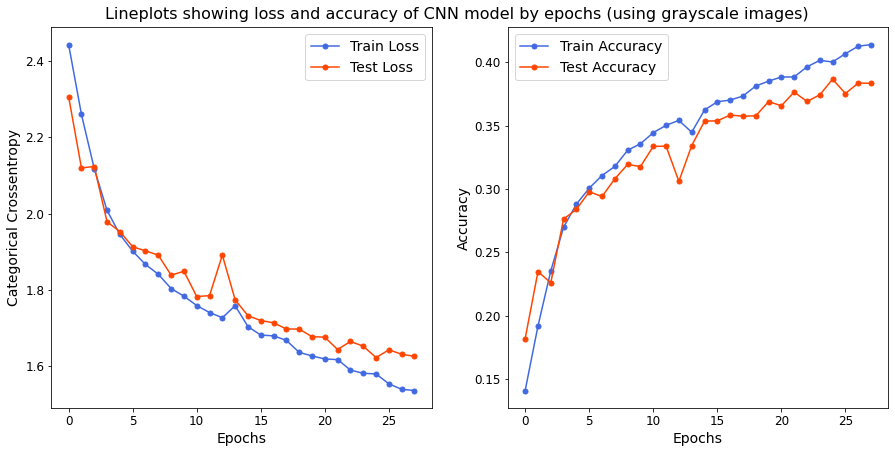

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss1, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss1, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy1, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy1, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs (using grayscale images)", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_classification_with_faces/plot_images/cnn1_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

cnn1_score = cnn1.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 5s 244ms/step - loss: 1.6252 - accuracy: 0.3834


In [ ]:
# Printing the relevant score summary.

cnn1_labels = cnn1.metrics_names
print(f'CNN_1 model {cnn1_labels[0]} \t= {round(cnn1_score[0], 3)}')
print(f'CNN_1 model {cnn1_labels[1]} \t= {round(cnn1_score[1], 3)}')

CNN_1 model loss 	= 1.625
CNN_1 model accuracy 	= 0.383


In [ ]:
# Saving the model as a h5 file for possible use later.

cnn1.save(f"/content/drive/My Drive/Age_classification_with_faces/input_output/cnn1_model_acc_{round(cnn1_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

cnn1_pred = cnn1.predict(test_dataset)
cnn1_pred = cnn1_pred.argmax(axis=-1)

In [ ]:
len(cnn1_pred)

10046

In [ ]:
len(test_labels_list)

10046

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat1 = confusion_matrix(test_labels_list, cnn1_pred)
conf_mat1

array([[760, 170,   3,   9,   6,   0,   5,   2,   2,   1,   0],
       [110, 512, 109,  63,  16,   2,  16,   9,   2,   3,   3],
       [  7, 121, 400, 279,  33,  12,  53,  31,   1,   2,   2],
       [  4,  27,  93, 635,  72,  32, 129,  40,   3,   4,   3],
       [  1,  24,  32, 440, 135,  51, 168,  93,  11,   8,   2],
       [  0,  23,  50, 359,  70,  46, 217, 122,  24,   5,   3],
       [  2,  10,  20, 261,  79,  40, 280, 182,  44,   5,   3],
       [  4,   9,  33, 150,  59,  35, 263, 288,  85,  22,  14],
       [  2,   8,  25,  41,  21,  16, 178, 248, 181,  51,  69],
       [  0,   5,  27,  25,  16,   8,  87, 174, 214, 139, 144],
       [  5,   7,   9,   6,   9,   1,  32,  57,  96, 111, 476]])

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Age_classification_with_faces/plot_images/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


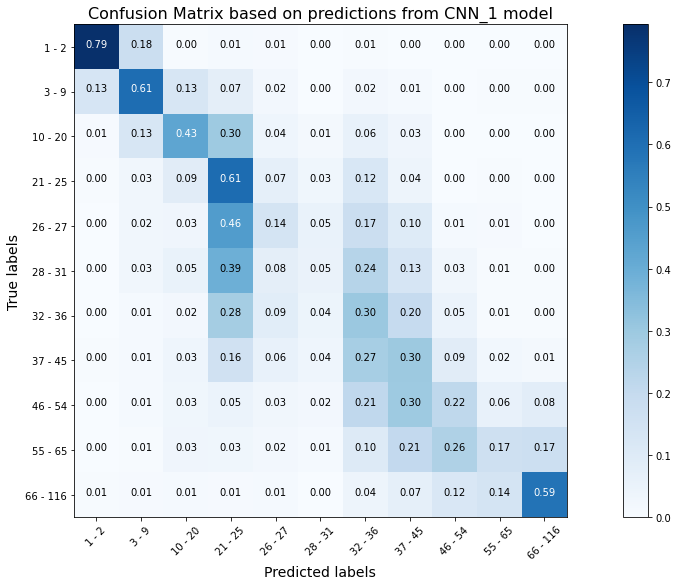

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat1, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN_1 model",
                      export_as="cnn1_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


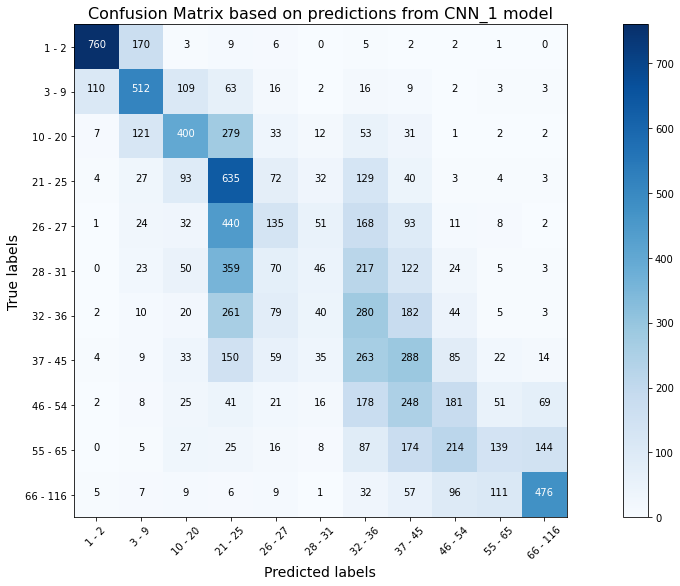

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat1, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN_1 model",
                      export_as="cnn1_conf_mat"
                     )

plt.show()

In [ ]:
# Creating a new dataframe to store all the CNN models summary scores.

cnn_summary_df = pd.DataFrame(columns=['Model Description', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy'])

In [ ]:
# Creating and saving the summary dataframe with the above model scores.

cnn_summary_df.loc[1] = {'Model Description' : 'CNN with grayscale images; 28 epochs',
                         'Train Loss' : round(train_loss1[-1], 4),
                         'Val Loss' : round(test_loss1[-1], 4),
                         'Train Accuracy' : round(train_accuracy1[-1], 4),
                         'Val Accuracy' : round(test_accuracy1[-1], 4)
                        }

cnn_summary_df.to_csv("/content/drive/My Drive/Age_classification_with_faces/input_output/cnn_models_summary.csv", index=False)
cnn_summary_df

,Model Description,Train Loss,Val Loss,Train Accuracy,Val Accuracy
1,CNN with grayscale images; 28 epochs,1.5355,1.6252,0.414,0.3834


As seen above, the overall accuracy for the CNN model is quite low (~40%). The model performance is not that great, but is a **good starting point with only slight over-fitting**.

Observing from the normalized confusion matrix above, it is evident that, **similar to the traditional ML approach**, even though the accuracy values are somewhat high for the younger age-ranges (of 1–2, 3–9, 10–20 and 21–25) and for the older age ranges (of 66–116), there is a **presence of significant misclassification for the middle age-ranges of 26–65**. This may be attributed to the fact that people's facial appearances (in general) do not change as much during these middle age ranges as they do during the younger and older age ranges.

In any case, the next step in this process is to improve the model’s performance using a few different techniques, as discussed below.

In order to improve the accuracy of the neural network, I will now try the following strategies:
1. **Using RGB coloured images instead of grayscale images** - The rationale behind this is that maybe adding the colour data in the images may bring out some features within the CNN model which may enhance the overall performance of the model.
2. **Augmenting the images in training dataset** - The rationale behind this is that increasing the amount of data for the model to train with would help to increase the variance in the dataset. This may improve the model's accuracy whilst decreasing the possibility of over-fit.
3. **Re-distributing the age-range classes** - To improve the overall accuracy scores, and to mainly address the misclassification issue for the middle age-ranges of 26-65, I will re-distribute the age-ranges into classes again. This time, however, instead of just looking at the available number of images per age-range, I will also take into account the human intuition factor (likely age groups that we, as humans, would classify a person into) and the accuracy scores for the individual classes shown in the confusion matrix above.
4. **Optimizing the CNN model architecture** - After exploring the above techniques of manipulating the dataset to improve the preformance of the CNN models, I will optimize the CNN model architecture itself to enhance the overall performance. The idea here is to design multiple models of different architectures and compare their performances in terms of loss and accuracy values using *TensorBoard*.

### CNN using RGB Coloured Facial Images

The rationale behind this is that **maybe adding the colour data in the images may bring out some features within the CNN model which may enhance the overall performance of the model**.

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Redefining the function to read, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 1 to 3 changes the output images from grayscale to RGB coloured.

num_classes = 11

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(3)
train_dataset = train_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

cnn2 = Sequential()

cnn2.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(200, 200, 3)))    # 3rd dim = 3 for RGB coloured images.
cnn2.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn2.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2,2)))

cnn2.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2,2)))

cnn2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2,2)))

cnn2.add(GlobalAveragePooling2D())

cnn2.add(Dense(20, activation='relu'))
cnn2.add(Dense(11, activation='softmax'))

cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 198, 198, 8)       224       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 196, 196, 16)      1168      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 194, 194, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 95, 95, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
# Compiling the neural network defined above.

cnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fitting the model.

cnn2_history = cnn2.fit(train_dataset,
                        batch_size=512,
                        validation_data=test_dataset,
                        epochs=30,
                        callbacks=[early_stop],
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
138/138 [==============================] - 129s 933ms/step - loss: 2.4998 - accuracy: 0.1473 - val_loss: 2.2661 - val_accuracy: 0.2021
Epoch 2/30
138/138 [==============================] - 133s 961ms/step - loss: 2.1704 - accuracy: 0.2266 - val_loss: 2.0556 - val_accuracy: 0.2563
Epoch 3/30
138/138 [==============================] - 133s 966ms/step - loss: 1.9941 - accuracy: 0.2698 - val_loss: 1.9469 - val_accuracy: 0.2860
Epoch 4/30
138/138 [==============================] - 133s 962ms/step - loss: 1.9017 - accuracy: 0.2947 - val_loss: 1.8776 - val_accuracy: 0.3030
Epoch 5/30
138/138 [==============================] - 133s 962ms/step - loss: 1.8523 - accuracy: 0.3104 - val_loss: 1.8895 - val_accuracy: 0.2939
Epoch 6/30
138/138 [==============================] - 132s 959ms/step - loss: 1.8094 - accuracy: 0.3227 - val_loss: 1.8252 - val_accuracy: 0.3111
Epoch 7/30
138/138 [==============================] - 133s 961ms/step - loss: 1.7763 - accuracy: 0.3336 - val_loss: 1.7941 -

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss2 = cnn2_history.history['loss']
test_loss2 = cnn2_history.history['val_loss']
train_accuracy2 = cnn2_history.history['accuracy']
test_accuracy2 = cnn2_history.history['val_accuracy']

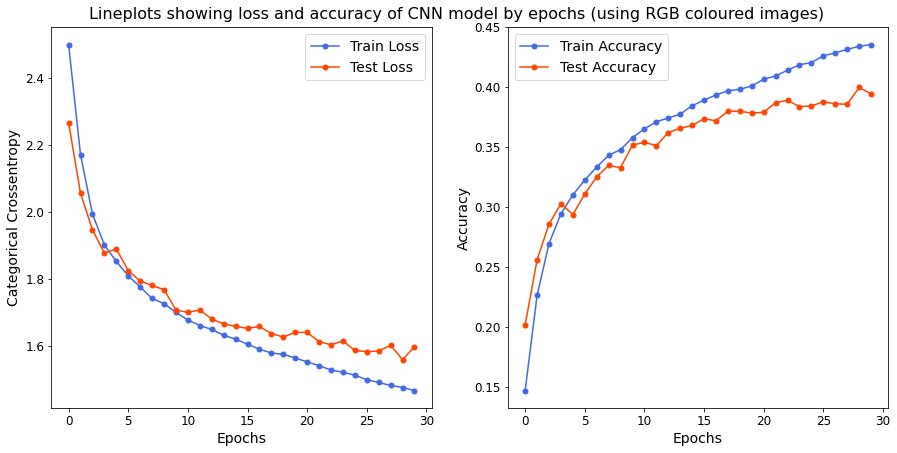

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss2, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss2, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy2, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy2, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs (using RGB coloured images)", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_classification_with_faces/plot_images/cnn2_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

cnn2_score = cnn2.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 6s 286ms/step - loss: 1.5971 - accuracy: 0.3946


In [ ]:
# Printing the relevant score summary.

cnn2_labels = cnn2.metrics_names

print(f'CNN_1 model {cnn1_labels[0]} \t= {round(cnn1_score[0], 3)}')
print(f'CNN_1 model {cnn1_labels[1]} \t= {round(cnn1_score[1], 3)}')
print()
print(f'CNN_2 model {cnn2_labels[0]} \t= {round(cnn2_score[0], 3)}')
print(f'CNN_2 model {cnn2_labels[1]} \t= {round(cnn2_score[1], 3)}')

CNN_1 model loss 	= 1.625
CNN_1 model accuracy 	= 0.383

CNN_2 model loss 	= 1.597
CNN_2 model accuracy 	= 0.395


In [ ]:
# Saving the model as a h5 file for possible use later.

cnn2.save(f"/content/drive/My Drive/Age_classification_with_faces/input_output/cnn2_model_acc_{round(cnn2_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

cnn2_pred = cnn2.predict(test_dataset)
cnn2_pred = cnn2_pred.argmax(axis=-1)

In [ ]:
len(cnn2_pred)

10046

In [ ]:
len(test_labels_list)

10046

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat2 = confusion_matrix(test_labels_list, cnn2_pred)
conf_mat2

array([[894,  56,   4,   1,   1,   0,   0,   0,   0,   2,   0],
       [197, 528,  86,  10,   8,   4,   0,   3,   1,   3,   5],
       [ 13, 228, 452, 135,  32,  47,   3,  19,   2,   8,   2],
       [ 15,  72, 198, 448,  72, 149,  21,  42,  10,  13,   2],
       [ 19,  45, 101, 290, 158, 209,  25,  74,  14,  27,   3],
       [  6,  47, 125, 233,  81, 223,  28, 111,  25,  38,   2],
       [ 12,  41,  95, 158,  84, 220,  42, 176,  44,  53,   1],
       [  7,  38,  73,  90,  64, 202,  42, 240,  99,  97,  10],
       [  3,  25,  50,  35,  34,  95,  19, 162, 125, 252,  40],
       [  8,  24,  39,  11,  14,  38,  15,  95,  76, 403, 116],
       [ 13,  16,   8,   5,   9,   7,   2,  27,  20, 251, 451]])

Normalized confusion matrix


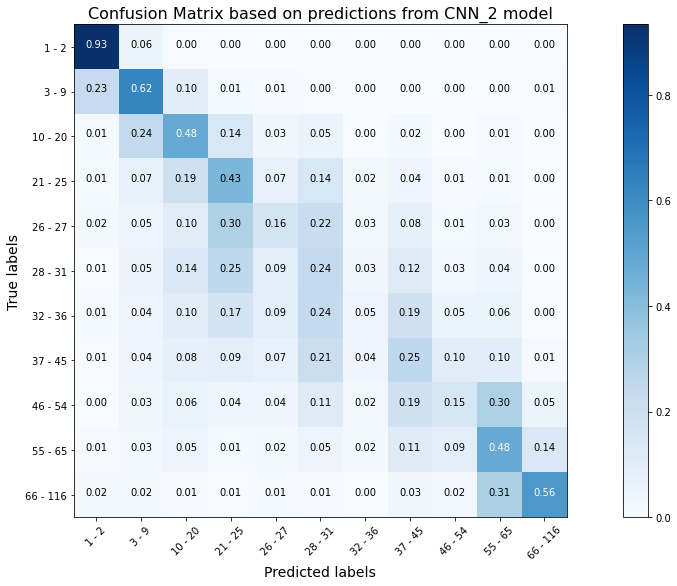

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat2, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN_2 model",
                      export_as="cnn2_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


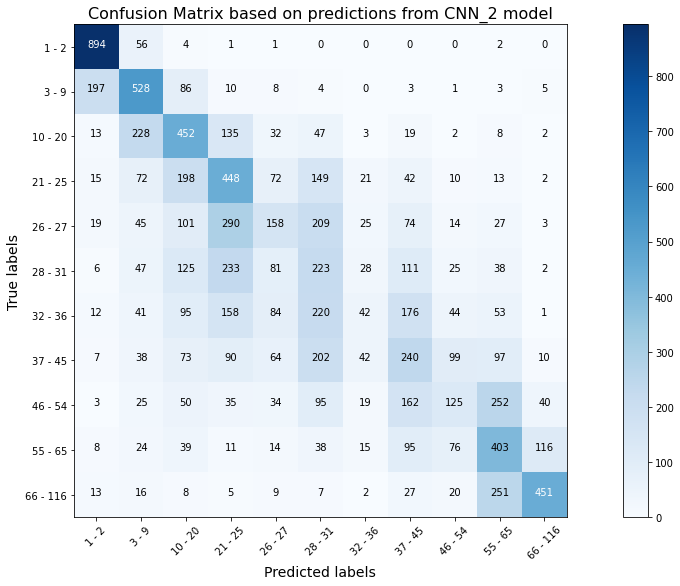

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat2, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN_2 model",
                      export_as="cnn2_conf_mat"
                     )

plt.show()

In [ ]:
# Creating and saving the summary dataframe with the above model scores.

cnn_summary_df.loc[2] = {'Model Description' : 'CNN with RGB coloured images; 30 epochs',
                         'Train Loss' : round(train_loss2[-1], 4),
                         'Val Loss' : round(test_loss2[-1], 4),
                         'Train Accuracy' : round(train_accuracy2[-1], 4),
                         'Val Accuracy' : round(test_accuracy2[-1], 4)
                        }

cnn_summary_df.to_csv("/content/drive/My Drive/Age_classification_with_faces/input_output/cnn_models_summary.csv", index=False)
cnn_summary_df

,Model Description,Train Loss,Val Loss,Train Accuracy,Val Accuracy
1,CNN with grayscale images; 28 epochs,1.5355,1.6252,0.4140,0.3834
2,CNN with RGB coloured images; 30 epochs,1.4672,1.5971,0.4356,0.3946


As seen above, the overall accuracy for the CNN model using **RGB coloured images** is still quite low (~40%). It is **slightly better than the previous CNN model using grayscale images, although with a slighlty higher degree of over-fitting**. Observing from the normalized confusion matrix above, it is evident that the problem of misclassification for the middle age-ranges of 26-54 still persists.

Since using RGB coloured images instead of grayscale images did not really add any significant improvements in terms of accuracy, it can be concluded that **using RGB coloured images instead of grayscale images may not improve the model performance and may lead to more over-fit**. So, I will continue to use grayscale images in the models that will be built in the following sections.

### CNN after Augmenting Training Dataset

Data augmentation helps to increase the size of the dataset by generating more images of different orientations from existing ones. This helps to increase the variance in the dataset, thus reducing the possibility of over-fitting, while also [improving accuracy](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b).

For the purposes of this project, data augmentation was done on the training dataset comprising of 23,440 images. **Each of the images were flipped laterally, and then the original and the laterally flipped images were rotated to 40, 20, -20 & -40 degrees** (as illustrated below). Thus, for every 1 original image, 9 other augmented images were generated, taking the **size of the training dataset from 23,440 images to 234,400 images**.

![image_data_augmentation.png](https://drive.google.com/uc?export=view&id=1JKimtQPusjj3Ct9WYHf7JWbAkkf0wAmV)

Data augmentation was done in notebook ***4_5_training_data_augmentation.ipynb***. The augmented dataset was saved as a new zip file, which will be imported below for usage in the CNN model.

In [ ]:
# Unzipping the dataset file combined_faces_train_augmented.zip

combined_faces_zip_path = "/content/drive/My Drive/Faces_datasets/zipped_datasets/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [ ]:
# Importing the augmented training dataset to create tensors of images using the filename paths.

train_aug_df = pd.read_csv("/content/drive/My Drive/Age_classification_with_faces/input_output/images_filenames_labels_train_augmented.csv")

In [ ]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,7
1,/content/content/combined_faces_train_augmente...,71,10
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [ ]:
train_aug_df.shape

(234400, 3)

In [ ]:
# Converting the filenames and target class labels into lists for the augmented train dataset.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Redefining the function to read, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 11

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

cnn3 = Sequential()

cnn3.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
cnn3.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn3.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2)))

cnn3.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2)))

cnn3.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2,2)))

cnn3.add(GlobalAveragePooling2D())
cnn3.add(Dense(20, activation='relu'))
cnn3.add(Dense(11, activation='softmax'))

cnn3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 198, 198, 8)       80        
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 196, 196, 16)      1168      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 194, 194, 32)      4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 95, 95, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
# Compiling the neural network defined above.

cnn3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fitting the model.

cnn3_history = cnn3.fit(train_aug_dataset,
                        batch_size=512,
                        validation_data=test_dataset,
                        epochs=30,
                        callbacks=[early_stop],
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
458/458 [==============================] - 393s 859ms/step - loss: 2.3315 - accuracy: 0.1630 - val_loss: 2.3026 - val_accuracy: 0.1780
Epoch 2/30
458/458 [==============================] - 374s 817ms/step - loss: 2.0604 - accuracy: 0.2507 - val_loss: 1.9718 - val_accuracy: 0.2810
Epoch 3/30
458/458 [==============================] - 374s 817ms/step - loss: 1.9123 - accuracy: 0.2937 - val_loss: 1.8651 - val_accuracy: 0.3131
Epoch 4/30
458/458 [==============================] - 377s 824ms/step - loss: 1.8388 - accuracy: 0.3148 - val_loss: 1.8193 - val_accuracy: 0.3218
Epoch 5/30
458/458 [==============================] - 380s 830ms/step - loss: 1.7919 - accuracy: 0.3289 - val_loss: 1.7472 - val_accuracy: 0.3442
Epoch 6/30
458/458 [==============================] - 390s 851ms/step - loss: 1.7619 - accuracy: 0.3371 - val_loss: 1.7325 - val_accuracy: 0.3506
Epoch 7/30
458/458 [==============================] - 402s 877ms/step - loss: 1.7286 - accuracy: 0.3472 - val_loss: 1.7018 -

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss3 = cnn3_history.history['loss']
test_loss3 = cnn3_history.history['val_loss']
train_accuracy3 = cnn3_history.history['accuracy']
test_accuracy3 = cnn3_history.history['val_accuracy']

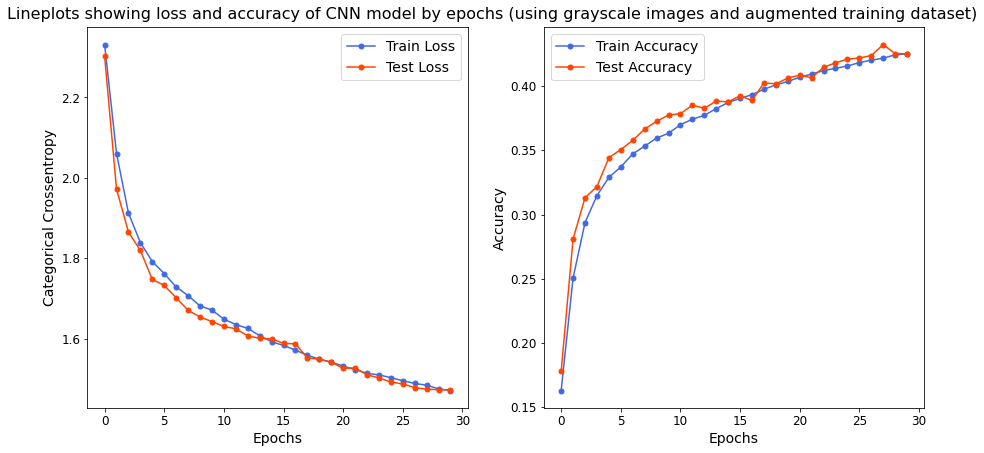

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss3, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss3, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy3, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy3, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs (using grayscale images and augmented training dataset)", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_classification_with_faces/plot_images/cnn3_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

cnn3_score = cnn3.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 4s 221ms/step - loss: 1.4727 - accuracy: 0.4252


In [ ]:
# Printing the relevant score summary.

cnn3_labels = cnn3.metrics_names

print(f'CNN_1 model {cnn1_labels[0]} \t= {round(cnn1_score[0], 3)}')
print(f'CNN_1 model {cnn1_labels[1]} \t= {round(cnn1_score[1], 3)}')
print()
print(f'CNN_2 model {cnn2_labels[0]} \t= {round(cnn2_score[0], 3)}')
print(f'CNN_2 model {cnn2_labels[1]} \t= {round(cnn2_score[1], 3)}')
print()
print(f'CNN_3 model {cnn3_labels[0]} \t= {round(cnn3_score[0], 3)}')
print(f'CNN_3 model {cnn3_labels[1]} \t= {round(cnn3_score[1], 3)}')

CNN_1 model loss 	= 1.625
CNN_1 model accuracy 	= 0.383

CNN_2 model loss 	= 1.597
CNN_2 model accuracy 	= 0.395

CNN_3 model loss 	= 1.473
CNN_3 model accuracy 	= 0.425


In [ ]:
# Saving the model as a h5 file for possible use later.

cnn3.save(f"/content/drive/My Drive/Age_classification_with_faces/input_output/cnn3_model_acc_{round(cnn3_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

cnn3_pred = cnn3.predict(test_dataset)
cnn3_pred = cnn3_pred.argmax(axis=-1)

In [ ]:
len(cnn3_pred)

10046

In [ ]:
len(test_labels_list)

10046

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat3 = confusion_matrix(test_labels_list, cnn3_pred)
conf_mat3

array([[838, 112,   1,   1,   1,   1,   0,   4,   0,   0,   0],
       [117, 636,  41,   5,  19,   3,   3,  10,   1,   4,   6],
       [  4, 251, 357, 109, 120,  19,  29,  36,   4,   6,   6],
       [  8,  44, 117, 389, 294,  34,  89,  60,   4,   2,   1],
       [  2,  31,  49, 181, 464,  32,  94,  91,  11,   9,   1],
       [  2,  23,  42, 172, 260,  58, 168, 135,  37,  15,   7],
       [  2,  24,  22,  88, 250,  43, 180, 237,  51,  26,   3],
       [  1,  16,  21,  40, 174,  22, 170, 300, 114,  98,   6],
       [  1,  14,  22,  11,  49,  10,  69, 242, 166, 195,  61],
       [  0,  14,  11,   5,  29,   2,  28, 144, 100, 341, 165],
       [  2,   7,   2,   0,  15,   4,   2,  31,  31, 172, 543]])

Normalized confusion matrix


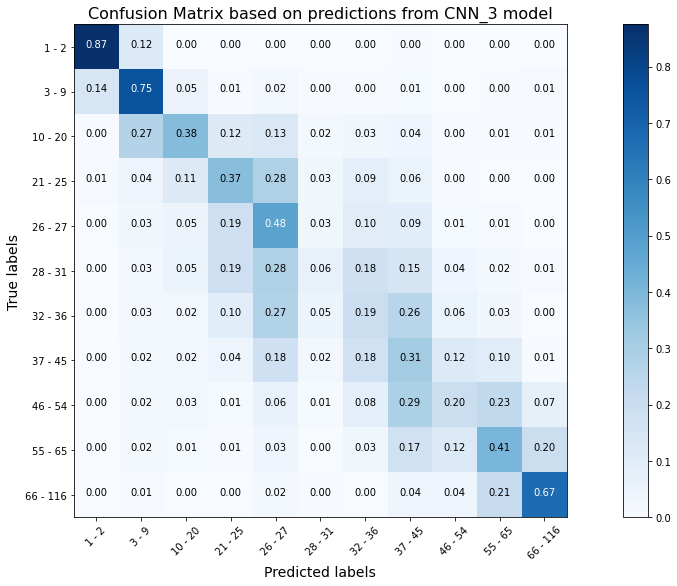

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat3, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN_3 model",
                      export_as="cnn3_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


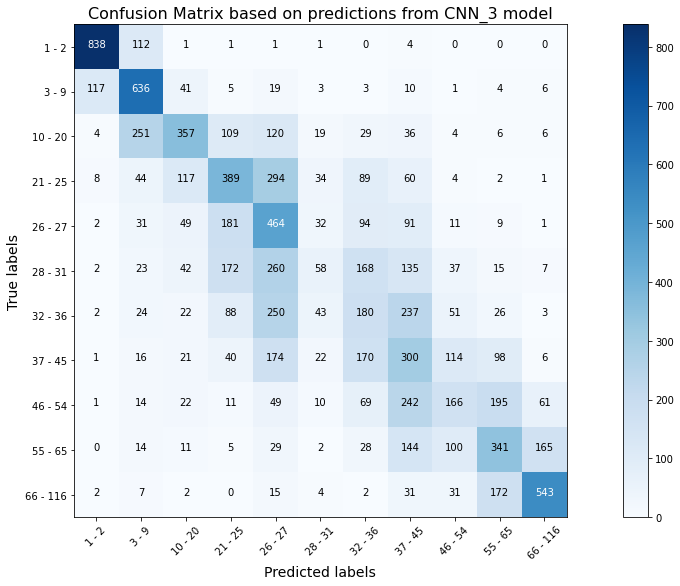

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat3, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN_3 model",
                      export_as="cnn3_conf_mat"
                     )

plt.show()

In [ ]:
# Creating and saving the summary dataframe with the above model scores.

cnn_summary_df.loc[3] = {'Model Description' : 'CNN with grayscale images; Aug train set; 30 epochs',
                         'Train Loss' : round(train_loss3[-1], 4),
                         'Val Loss' : round(test_loss3[-1], 4),
                         'Train Accuracy' : round(train_accuracy3[-1], 4),
                         'Val Accuracy' : round(test_accuracy3[-1], 4)
                        }

cnn_summary_df.to_csv("/content/drive/My Drive/Age_classification_with_faces/input_output/cnn_models_summary.csv", index=False)
cnn_summary_df

,Model Description,Train Loss,Val Loss,Train Accuracy,Val Accuracy
1,CNN with grayscale images; 28 epochs,1.5355,1.6252,0.4140,0.3834
2,CNN with RGB coloured images; 30 epochs,1.4672,1.5971,0.4356,0.3946
3,CNN with grayscale images; Aug train set; 30 e...,1.4710,1.4727,0.4251,0.4252


#### Fitting for further 30 epochs

**As the model above showed no over-fitting after 30 epochs, it will be set to train for further 30 epochs. As seen from the lineplots above, this may also improve the accuracy further (since it is still climbing) and decrease the loss.**

In [ ]:
cnn3_history = cnn3.fit(train_aug_dataset,
                        batch_size=512,
                        validation_data=test_dataset,
                        epochs=30,
                        callbacks=[early_stop],
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
458/458 [==============================] - 363s 794ms/step - loss: 1.4682 - accuracy: 0.4263 - val_loss: 1.4675 - val_accuracy: 0.4266
Epoch 2/30
458/458 [==============================] - 363s 792ms/step - loss: 1.4616 - accuracy: 0.4286 - val_loss: 1.4575 - val_accuracy: 0.4315
Epoch 3/30
458/458 [==============================] - 364s 794ms/step - loss: 1.4564 - accuracy: 0.4299 - val_loss: 1.4528 - val_accuracy: 0.4353
Epoch 4/30
458/458 [==============================] - 369s 807ms/step - loss: 1.4542 - accuracy: 0.4308 - val_loss: 1.4475 - val_accuracy: 0.4376
Epoch 5/30
458/458 [==============================] - 365s 797ms/step - loss: 1.4450 - accuracy: 0.4334 - val_loss: 1.4462 - val_accuracy: 0.4360
Epoch 6/30
458/458 [==============================] - 370s 807ms/step - loss: 1.4417 - accuracy: 0.4347 - val_loss: 1.4390 - val_accuracy: 0.4397
Epoch 7/30
458/458 [==============================] - 362s 791ms/step - loss: 1.4390 - accuracy: 0.4351 - val_loss: 1.4352 -

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss3_1 = cnn3_history.history['loss']
test_loss3_1 = cnn3_history.history['val_loss']
train_accuracy3_1 = cnn3_history.history['accuracy']
test_accuracy3_1 = cnn3_history.history['val_accuracy']

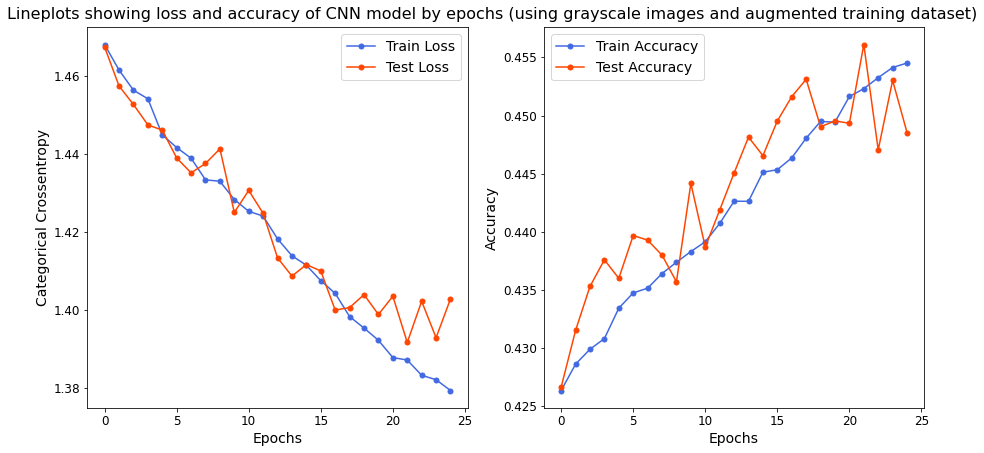

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss3_1, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss3_1, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy3_1, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy3_1, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs (using grayscale images and augmented training dataset)", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_classification_with_faces/plot_images/cnn3_1_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

cnn3_1_score = cnn3.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 5s 237ms/step - loss: 1.4028 - accuracy: 0.4485


In [ ]:
# Printing the relevant score summary.

cnn3_labels = cnn3.metrics_names

print(f'CNN_1 model {cnn1_labels[0]} \t= {round(cnn1_score[0], 3)}')
print(f'CNN_1 model {cnn1_labels[1]} \t= {round(cnn1_score[1], 3)}')
print()
print(f'CNN_2 model {cnn2_labels[0]} \t= {round(cnn2_score[0], 3)}')
print(f'CNN_2 model {cnn2_labels[1]} \t= {round(cnn2_score[1], 3)}')
print()
print(f'CNN_3 model {cnn3_labels[0]} \t= {round(cnn3_score[0], 3)}')
print(f'CNN_3 model {cnn3_labels[1]} \t= {round(cnn3_score[1], 3)}')
print()
print(f'CNN_3 model {cnn3_labels[0]} \t= {round(cnn3_1_score[0], 3)}')
print(f'CNN_3 model {cnn3_labels[1]} \t= {round(cnn3_1_score[1], 3)}')

CNN_1 model loss 	= 1.625
CNN_1 model accuracy 	= 0.383

CNN_2 model loss 	= 1.597
CNN_2 model accuracy 	= 0.395

CNN_3 model loss 	= 1.473
CNN_3 model accuracy 	= 0.425

CNN_3 model loss 	= 1.403
CNN_3 model accuracy 	= 0.449


In [ ]:
# Saving the model as a h5 file for possible use later.

cnn3.save(f"/content/drive/My Drive/Age_classification_with_faces/input_output/cnn3_1_model_acc_{round(cnn3_1_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

cnn3_1_pred = cnn3.predict(test_dataset)
cnn3_1_pred = cnn3_1_pred.argmax(axis=-1)

In [ ]:
len(cnn3_1_pred)

10046

In [ ]:
len(test_labels_list)

10046

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat3_1 = confusion_matrix(test_labels_list, cnn3_1_pred)
conf_mat3_1

array([[869,  78,   0,   1,   4,   0,   0,   4,   1,   1,   0],
       [117, 612,  61,   6,  25,   1,   4,   5,   3,   4,   7],
       [  3, 167, 428, 129, 119,  19,  22,  31,  13,   6,   4],
       [  6,  16,  95, 444, 268,  41,  90,  67,   9,   6,   0],
       [  3,  11,  28, 198, 438,  41, 119,  98,  14,  14,   1],
       [  1,   6,  25, 180, 244,  49, 186, 162,  41,  18,   7],
       [  5,   7,  12,  93, 212,  37, 203, 253,  71,  31,   2],
       [  1,   8,   7,  36, 143,  19, 175, 308, 157,  98,  10],
       [  1,   3,   9,  12,  43,   3,  74, 193, 226, 221,  55],
       [  0,   4,   5,   1,  17,   1,  19, 122, 131, 367, 172],
       [  1,   2,   2,   0,   9,   1,   7,  23,  36, 166, 562]])

Normalized confusion matrix


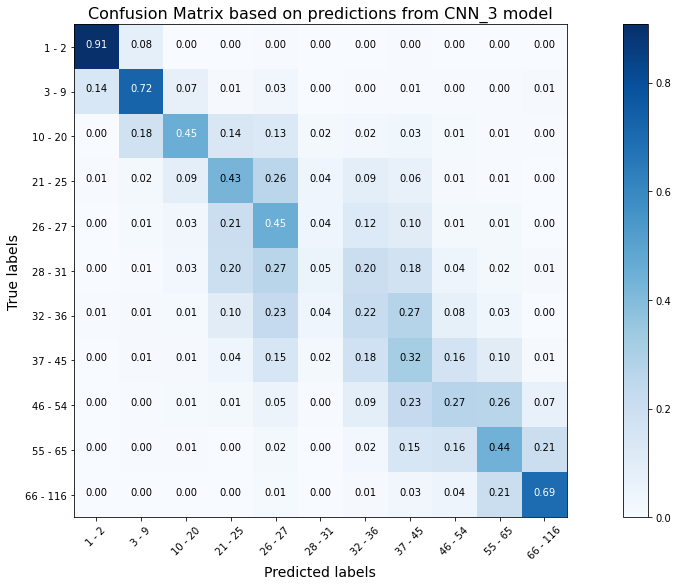

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat3_1, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN_3 model",
                      export_as="cnn3_1_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


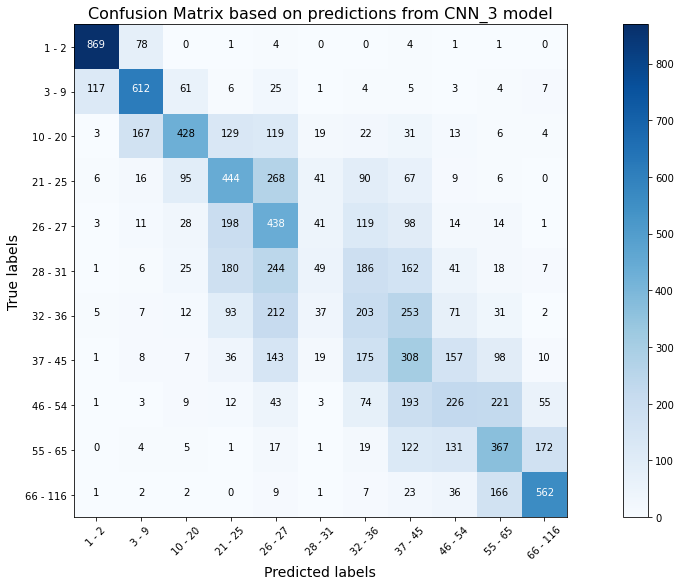

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = combined_classes['Age-ranges (classes)']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat3_1, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN_3 model",
                      export_as="cnn3_1_conf_mat"
                     )

plt.show()

In [ ]:
# Creating and saving the summary dataframe with the above model scores.

cnn_summary_df.loc[4] = {'Model Description' : 'CNN with grayscale images; Aug train set; 30+ epochs',
                         'Train Loss' : round(train_loss3_1[-1], 4),
                         'Val Loss' : round(test_loss3_1[-1], 4),
                         'Train Accuracy' : round(train_accuracy3_1[-1], 4),
                         'Val Accuracy' : round(test_accuracy3_1[-1], 4)
                        }

cnn_summary_df.to_csv("/content/drive/My Drive/Age_classification_with_faces/input_output/cnn_models_summary.csv", index=False)
cnn_summary_df

,Model Description,Train Loss,Val Loss,Train Accuracy,Val Accuracy
1,CNN with grayscale images; 28 epochs,1.5355,1.6252,0.4140,0.3834
2,CNN with RGB coloured images; 30 epochs,1.4672,1.5971,0.4356,0.3946
3,CNN with grayscale images; Aug train set; 30 e...,1.4710,1.4727,0.4251,0.4252
4,CNN with grayscale images; Aug train set; 30+ ...,1.3793,1.4028,0.4545,0.4485


As seen above, the overall accuracy for the CNN model using the augmented training dataset improved slightly, while the degree of over-fitting reduced even after training for double the number of epochs (60 epochs instead of 30). So, it can be concluded that **augmenting the images in the training dataset may help to improve the model's accuracy whilst decreasing the over-fit**.

### CNN after Re-distributing Age-range Classes

In [ ]:
combined_classes

,Class label,Age-ranges (classes),No. of images,Class balance (%)
0,0,1 - 2,3192,9.53
1,1,3 - 9,2816,8.41
2,2,10 - 20,3136,9.37
3,3,21 - 25,3474,10.37
4,4,26 - 27,3217,9.61
5,5,28 - 31,3063,9.15
6,6,32 - 36,3086,9.22
7,7,37 - 45,3207,9.58
8,8,46 - 54,2802,8.37
9,9,55 - 65,2796,8.35


Looking at the evaluations of all the CNN models built above, it is clear that the accuracy scores are not very high (~45% at best). This is, in fact, rather expected, since **guessing someone's age is purely based on appearance, and thus very subjective**. Even we as humans struggle with this problem all the time. There are a lot of factors that play a role in how someone looks at their age, such as genetics, living conditions and lifestyle choices (healthy diet, amount of exercise, smoking habit, etc.).

As we have seen above, even with data augmentation, the accuracy score did not improve significantly. The **primary issue is still the fact that there is a presence of significant misclassification for the middle age-ranges of 26–65**. So, to avoid this problem, I will re-distribute the age-ranges into classes again. This time, however, instead of just looking at the available number of images per age-range, I will also take into account the **human intuition factor (likely age groups that we, as humans, would classify a person into)** and the accuracy scores for the individual classes shown in the confusion matrices above.

**Caveat** — *The approach detailed above implies that in this project, I am manipulating the data science problem itself to better fit the solution I am  trying to propose. This may obviously not be an ideal approach in majority of the data science problems in the real-world. However, as mentioned earlier, since this project is not specifically aimed at solving a data science problem, the choice of division of age-ranges into classes is quite flexible. Given the fact that there are no major consequences to re-distributing the classes of age-ranges for age detection, I believe this approach is justified in this scenario.*

Thus, the **age-ranges will be re-distributed into the 7 classes as follows (age in years): *1-2, 3-9, 10-20, 21-27, 28-45, 46-65* and *66-116***.

In [ ]:
# Defining a function to return the class labels corresponding to the age-ranges shown above.

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [ ]:
train_df.head()

,filename,age,target
0,/content/content/combined_faces/18_369.jpg,18,2
1,/content/content/combined_faces/5_42.jpg,5,1
2,/content/content/combined_faces/5_204.jpg,5,1
3,/content/content/combined_faces/39_24.jpg,39,7
4,/content/content/combined_faces/22_41.jpg,22,3


In [ ]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,7
1,/content/content/combined_faces_train_augmente...,71,10
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,7
2,/content/content/combined_faces/40_177.jpg,40,7
3,/content/content/combined_faces/36_267.jpg,36,6
4,/content/content/combined_faces/8_349.jpg,8,1


In [ ]:
train_df['target_reassign'] = train_df['age'].map(class_labels_reassign)
train_aug_df['target_reassign'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target_reassign'] = test_df['age'].map(class_labels_reassign)

In [ ]:
train_df.head()

,filename,age,target,target_reassign
0,/content/content/combined_faces/18_369.jpg,18,2,2
1,/content/content/combined_faces/5_42.jpg,5,1,1
2,/content/content/combined_faces/5_204.jpg,5,1,1
3,/content/content/combined_faces/39_24.jpg,39,7,4
4,/content/content/combined_faces/22_41.jpg,22,3,3


In [ ]:
train_aug_df.head()

,filename,age,target,target_reassign
0,/content/content/combined_faces_train_augmente...,43,7,4
1,/content/content/combined_faces_train_augmente...,71,10,6
2,/content/content/combined_faces_train_augmente...,6,1,1
3,/content/content/combined_faces_train_augmente...,18,2,2
4,/content/content/combined_faces_train_augmente...,25,3,3


In [ ]:
test_df.head()

,filename,age,target,target_reassign
0,/content/content/combined_faces/8_163.jpg,8,1,1
1,/content/content/combined_faces/38_66.jpg,38,7,4
2,/content/content/combined_faces/40_177.jpg,40,7,4
3,/content/content/combined_faces/36_267.jpg,36,6,4
4,/content/content/combined_faces/8_349.jpg,8,1,1


In [ ]:
train_df['target_reassign'].value_counts(normalize=True)

4    0.279394
3    0.199829
5    0.167193
0    0.095307
2    0.093643
1    0.084087
6    0.080546
Name: target_reassign, dtype: float64

In [ ]:
train_aug_df['target_reassign'].value_counts(normalize=True)

4    0.279394
3    0.199829
5    0.167193
0    0.095307
2    0.093643
1    0.084087
6    0.080546
Name: target_reassign, dtype: float64

In [ ]:
test_df['target_reassign'].value_counts(normalize=True)

4    0.279415
3    0.199781
5    0.167131
0    0.095361
2    0.093669
1    0.084113
6    0.080530
Name: target_reassign, dtype: float64

In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(train_df['filename'])
train_labels_list = list(train_df['target_reassign'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target_reassign'])

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Redefining the function to read, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(3)
train_dataset = train_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

cnn4 = Sequential()

cnn4.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
cnn4.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn4.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2)))

cnn4.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2)))

cnn4.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2)))

cnn4.add(GlobalAveragePooling2D())

cnn4.add(Dense(20, activation='relu'))
cnn4.add(Dense(7, activation='softmax'))    # No. of nodes in output layer changed from 11 to 7 for the re-distributed age-range classes.

cnn4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 198, 198, 8)       80        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 196, 196, 16)      1168      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 194, 194, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 95, 95, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
# Compiling the neural network defined above.

cnn4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fitting the model.

cnn4_history = cnn4.fit(train_dataset,
                        batch_size=512,
                        validation_data=test_dataset,
                        epochs=30,
                        callbacks=[early_stop],
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
138/138 [==============================] - 95s 689ms/step - loss: 2.0091 - accuracy: 0.2768 - val_loss: 1.7016 - val_accuracy: 0.3058
Epoch 2/30
138/138 [==============================] - 101s 731ms/step - loss: 1.6019 - accuracy: 0.3589 - val_loss: 1.5600 - val_accuracy: 0.3843
Epoch 3/30
138/138 [==============================] - 93s 676ms/step - loss: 1.5310 - accuracy: 0.3888 - val_loss: 1.4989 - val_accuracy: 0.4066
Epoch 4/30
138/138 [==============================] - 90s 649ms/step - loss: 1.5168 - accuracy: 0.3956 - val_loss: 1.5248 - val_accuracy: 0.4013
Epoch 5/30
138/138 [==============================] - 90s 649ms/step - loss: 1.4469 - accuracy: 0.4234 - val_loss: 1.4058 - val_accuracy: 0.4411
Epoch 6/30
138/138 [==============================] - 89s 645ms/step - loss: 1.3790 - accuracy: 0.4427 - val_loss: 1.3765 - val_accuracy: 0.4512
Epoch 7/30
138/138 [==============================] - 95s 690ms/step - loss: 1.3323 - accuracy: 0.4613 - val_loss: 1.3212 - val_a

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss4 = cnn4_history.history['loss']
test_loss4 = cnn4_history.history['val_loss']
train_accuracy4 = cnn4_history.history['accuracy']
test_accuracy4 = cnn4_history.history['val_accuracy']

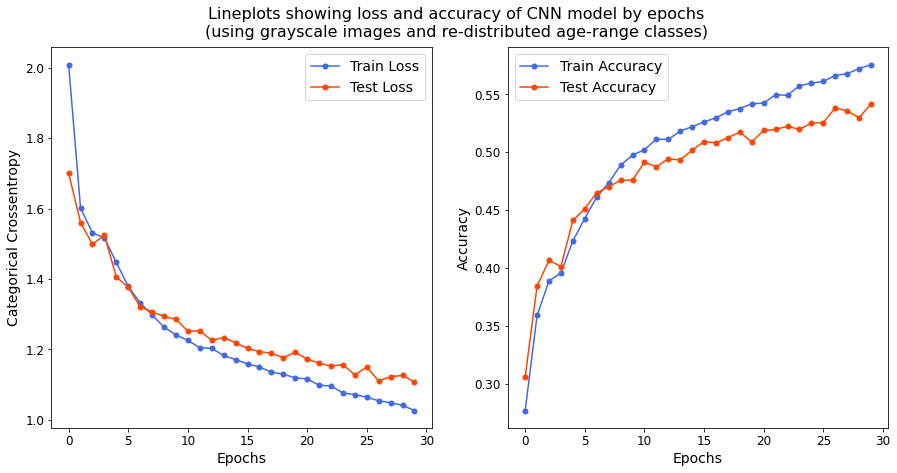

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss4, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss4, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy4, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy4, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.96, t="Lineplots showing loss and accuracy of CNN model by epochs\n(using grayscale images and re-distributed age-range classes)", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_classification_with_faces/plot_images/cnn4_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

cnn4_score = cnn4.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 5s 271ms/step - loss: 1.1075 - accuracy: 0.5417


In [ ]:
# Printing the relevant score summary.

cnn4_labels = cnn4.metrics_names

print(f'CNN_1 model {cnn1_labels[0]} \t= {round(cnn1_score[0], 3)}')
print(f'CNN_1 model {cnn1_labels[1]} \t= {round(cnn1_score[1], 3)}')
print()
print(f'CNN_2 model {cnn2_labels[0]} \t= {round(cnn2_score[0], 3)}')
print(f'CNN_2 model {cnn2_labels[1]} \t= {round(cnn2_score[1], 3)}')
print()
print(f'CNN_3 model {cnn3_labels[0]} \t= {round(cnn3_score[0], 3)}')
print(f'CNN_3 model {cnn3_labels[1]} \t= {round(cnn3_score[1], 3)}')
print()
print(f'CNN_3 model {cnn3_labels[0]} \t= {round(cnn3_1_score[0], 3)}')
print(f'CNN_3 model {cnn3_labels[1]} \t= {round(cnn3_1_score[1], 3)}')
print()
print(f'CNN_4 model {cnn4_labels[0]} \t= {round(cnn4_score[0], 3)}')
print(f'CNN_4 model {cnn4_labels[1]} \t= {round(cnn4_score[1], 3)}')

CNN_1 model loss 	= 1.625
CNN_1 model accuracy 	= 0.383

CNN_2 model loss 	= 1.597
CNN_2 model accuracy 	= 0.395

CNN_3 model loss 	= 1.473
CNN_3 model accuracy 	= 0.425

CNN_3 model loss 	= 1.403
CNN_3 model accuracy 	= 0.449

CNN_4 model loss 	= 1.107
CNN_4 model accuracy 	= 0.542


In [ ]:
# Saving the model as a h5 file for possible use later.

cnn4.save(f"/content/drive/My Drive/Age_classification_with_faces/input_output/cnn4_model_acc_{round(cnn4_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

cnn4_pred = cnn4.predict(test_dataset)
cnn4_pred = cnn4_pred.argmax(axis=-1)

In [ ]:
len(cnn4_pred)

10046

In [ ]:
len(test_labels_list)

10046

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat4 = confusion_matrix(test_labels_list, cnn4_pred)
conf_mat4

array([[ 826,   97,    2,   16,   11,    6,    0],
       [ 181,  457,  118,   36,   40,    7,    6],
       [  10,  163,  407,  168,  182,   11,    0],
       [  14,   47,  190,  863,  850,   41,    2],
       [  14,   54,  154,  558, 1845,  176,    6],
       [   6,   19,   62,   64,  733,  718,   77],
       [   4,   16,    5,   14,   87,  357,  326]])

Normalized confusion matrix


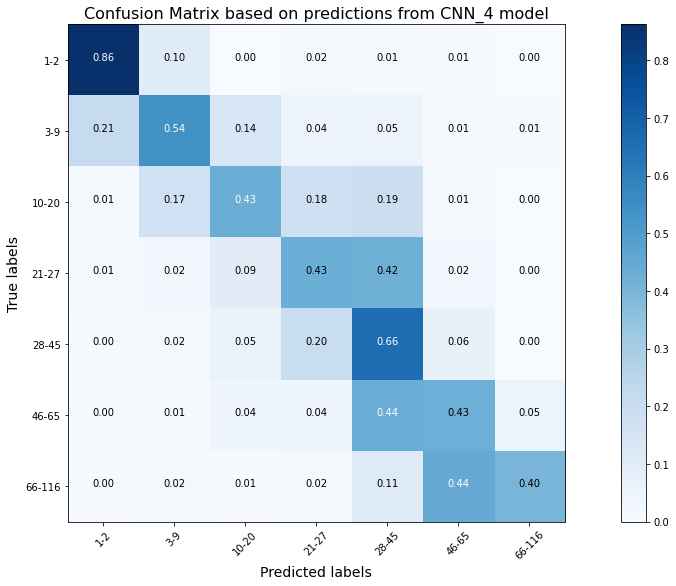

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat4, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN_4 model",
                      export_as="cnn4_conf_mat_norm"
                     )

plt.show()

Confusion matrix, without normalization


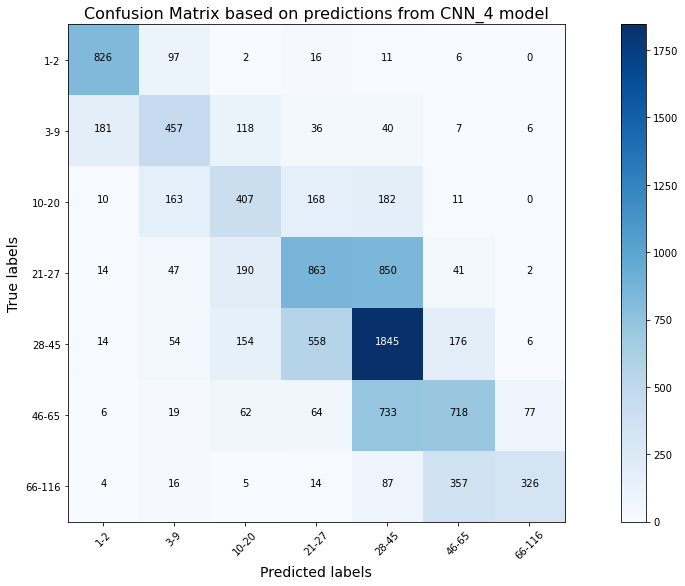

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat4, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from CNN_4 model",
                      export_as="cnn4_conf_mat"
                     )

plt.show()

In [ ]:
# Creating and saving the summary dataframe with the above model scores.

cnn_summary_df.loc[5] = {'Model Description' : 'CNN with grayscale images; Re-distributed age-ranges; 30 epochs',
                         'Train Loss' : round(train_loss4[-1], 4),
                         'Val Loss' : round(test_loss4[-1], 4),
                         'Train Accuracy' : round(train_accuracy4[-1], 4),
                         'Val Accuracy' : round(test_accuracy4[-1], 4)
                        }

cnn_summary_df.to_csv("/content/drive/My Drive/Age_classification_with_faces/input_output/cnn_models_summary.csv", index=False)
cnn_summary_df

,Model Description,Train Loss,Val Loss,Train Accuracy,Val Accuracy
1,CNN with grayscale images; 28 epochs,1.5355,1.6252,0.4140,0.3834
2,CNN with RGB coloured images; 30 epochs,1.4672,1.5971,0.4356,0.3946
3,CNN with grayscale images; Aug train set; 30 e...,1.4710,1.4727,0.4251,0.4252
4,CNN with grayscale images; Aug train set; 30+ ...,1.3793,1.4028,0.4545,0.4485
5,CNN with grayscale images; Re-distributed age-...,1.0265,1.1075,0.5758,0.5417


As seen above, the **accuracy scores show a similar degree of over-fit as the initial CNN model fit on grayscale images (which is expected), but the accuracy scores themselves are significantly higher**.

The normalized confusion matrix above also shows that I **may have addressed the problem of misclassification for the middle age-ranges of 26–65** (at least to some extent if not completely).

### Optimizing CNN Architecture

Now that I have explored a few techniques of manipulating the dataset to improve the preformance of the CNN models, I will optimize the CNN model architecture itself to enhance the overall performance. **The idea here is to design multiple models of different architectures and compare their performances in terms of loss and accuracy values.**

I will use ***TensorBoard*** as a callback while training the multiple CNN models so as to be able to compare their performances in interactive (and definitely more intuitive) plots. Refer to this [series of videos](https://www.youtube.com/playlist?list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN) to gain a better understanding on how to optimize neural networks using *TensorBoard*.

In [ ]:
train_df.head()

,filename,age,target,target_reassign
0,/content/content/combined_faces/18_369.jpg,18,2,2
1,/content/content/combined_faces/5_42.jpg,5,1,1
2,/content/content/combined_faces/5_204.jpg,5,1,1
3,/content/content/combined_faces/39_24.jpg,39,7,4
4,/content/content/combined_faces/22_41.jpg,22,3,3


In [ ]:
test_df.head()

,filename,age,target,target_reassign
0,/content/content/combined_faces/8_163.jpg,8,1,1
1,/content/content/combined_faces/38_66.jpg,38,7,4
2,/content/content/combined_faces/40_177.jpg,40,7,4
3,/content/content/combined_faces/36_267.jpg,36,6,4
4,/content/content/combined_faces/8_349.jpg,8,1,1


In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(train_df['filename'])
train_labels_list = list(train_df['target_reassign'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target_reassign'])

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Redefining the function to read, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(2)
train_dataset = train_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the numbers of Conv2D layers, Dense layers and types of Pooling2D layers for the optimization loop to run through. 

conv_layers = [1, 2, 3]
dense_layers = [0, 1, 2]
pooling = ['max', 'avg']    # Changing the pooling layers from MaxPooling2D to AveragePooling2D may have an impact on accuracy values as well. This will be tested here in this optimization process.

In [ ]:
# Defining a nested for-loop to run through the above defined combinations and create a CNN with the desired architecture for each combination.

model_counter = 0

for conv in conv_layers:
    for dense in dense_layers:
        for pool in pooling:
            
            model_counter += 1

            # Creating a unique name for each CNN model using combinations given above.
            cur_time = datetime.fromtimestamp(time.time()).strftime('%Y%m%d%H%M%S')
            model_name = f"cnn_{str(conv)}-conv_{str(dense)}-dense_{pool}-pool_{cur_time}"

            print(f"\n\nTRAINING MODEL {model_counter} OF 18 : {model_name}\n")

            # Creating a TensorBoard callback object and saving it at the desired location using model_name defined above.
            tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/Age_classification_with_faces/input_output/cnn_logs/{model_name}")

            # Creating a new sequential model.
            cnn = Sequential()

            # Input layer with 32 filters, followed by a Max or Average Pooling2D layer.
            cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
            if pool=='max':
                cnn.add(MaxPooling2D(pool_size=(2,2)))
            elif pool=='avg':
                cnn.add(AveragePooling2D(pool_size=(2,2)))
            
            # Creating Conv2D layers using the desired numbers defined above.
            # The no. of filters in these Conv2D layers will increase by factor of 2 for every successive Conv2D layer.
            conv_filters = 32
            for c in range(conv):
                conv_filters *= 2
                cnn.add(Conv2D(filters=conv_filters, kernel_size=3, activation='relu'))
                if pool=='max':
                    cnn.add(MaxPooling2D(pool_size=(2,2)))
                elif pool=='avg':
                    cnn.add(AveragePooling2D(pool_size=(2,2)))

            # Creating a GlobalAveragePooling2D layer before going into Dense layers below.
            # GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer.
            cnn.add(GlobalAveragePooling2D())

            # Creating Dense layers using the desired numbers defined above.
            # The no. of nodes in these Dense layers will taper down from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
            dense_nodes = int((conv_filters - 7) / (dense + 1))
            for d in range(dense):
                nodes = conv_filters - ((d+1) * dense_nodes)
                cnn.add(Dense(nodes, activation='relu'))
            
            # Output layer with 7 nodes (equal to the no. of classes).
            cnn.add(Dense(7, activation='softmax'))
            
            # Compiling the above created CNN architecture.
            cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Fitting the CNN model with the above created TensorBoard object as a callback.
            cnn.fit(train_dataset,
                    batch_size=512,
                    validation_data=test_dataset,
                    epochs=25,
                    callbacks=[early_stop, tensorboard],
                    shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                   )
            
            # Saving the model as a h5 file for possible use later.
            cnn.save(f"/content/drive/My Drive/Age_classification_with_faces/input_output/cnn_logs/{model_name}.h5", save_format='h5')



TRAINING MODEL 1 OF 18 : cnn_1-conv_0-dense_max-pool_20200620134430

Epoch 1/25
92/92 [==============================] - 48s 525ms/step - loss: 3.8911 - accuracy: 0.2229 - val_loss: 1.8666 - val_accuracy: 0.1754
Epoch 2/25
92/92 [==============================] - 48s 521ms/step - loss: 1.8133 - accuracy: 0.2784 - val_loss: 1.8345 - val_accuracy: 0.3096
Epoch 3/25
92/92 [==============================] - 48s 526ms/step - loss: 1.7419 - accuracy: 0.3077 - val_loss: 1.7492 - val_accuracy: 0.2999
Epoch 4/25
92/92 [==============================] - 48s 524ms/step - loss: 1.7641 - accuracy: 0.2933 - val_loss: 1.7320 - val_accuracy: 0.3283
Epoch 5/25
92/92 [==============================] - 48s 524ms/step - loss: 1.6983 - accuracy: 0.3219 - val_loss: 1.7177 - val_accuracy: 0.3264
Epoch 6/25
92/92 [==============================] - 48s 523ms/step - loss: 1.6650 - accuracy: 0.3373 - val_loss: 1.7134 - val_accuracy: 0.3322
Epoch 7/25
92/92 [==============================] - 48s 522ms/step - lo

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/drive/My\ Drive/Age_classification_with_faces/input_output/cnn_logs

Based on the performances of all the 18 models built above with varying architectures, and after analyzing all of them using *TensorBoard*, the **final CNN model** that will be built would have the following architecture:
1. an input *Conv2D* layer (with 32 filters) paired with an *AveragePooling2D* layer,
2. 3 pairs of *Conv2D* (with 64, 128 & 256 filters) and *AveragePooling2D* layers,
3. a *GlobalAveragePooling2D* layer,
4. 1 *Dense* layer with 132 nodes, and
5. an output *Dense* layer with 7 nodes.

## Deep Learning: Building Final CNN Model

Below is the **summary of all the CNN models built so far**.

![summary_table.png](https://drive.google.com/uc?export=view&id=1D6iYAbVaQFDo2ek4Bsj00BjxwviHZvlw)

After understanding the effects of all the improvement and optimization techniques on the CNN model performance, **the final CNN model can be defined and trained**:
1. with **grayscale images** instead of RGB coloured images.
2. with **augmented training dataset (234,400 images)** instead of original training dataset (23,440 images).
3. for **60 epochs**.
4. for **re-distributed classes of age-ranges**.
5. with an **optimized architecture**, comprising of:
- an input *Conv2D* layer (with 32 filters) paired with an *AveragePooling2D* layer,
- 3 pairs of *Conv2D* (with 64, 128 & 256 filters) and *AveragePooling2D* layers,
- a *GlobalAveragePooling2D* layer,
- 1 *Dense* layer with 132 nodes, and
- an output *Dense* layer with 7 nodes.

The final CNN model will be built in the next notebook ***5_deep_learning_final_CNN_model.ipynb***.